In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import datetime
from time import sleep
import os

In [2]:
# retrieve 100 df for the same topic, changing only one day to force getting different values
timeframe_tot = "2020-03-01 2020-06-01"  # common timeframe for total values
timeframe_part_a = "2020-03-01 2020-05-01"  # common timeframe for first interval
timeframe_part_b = "2020-04-01 2020-06-01"  # common timeframe for second interval
topic = "/m/0cjf0"
begin_tot, end_tot = [datetime.datetime.strptime(i, "%Y-%m-%d").date() for i in timeframe_tot.split()]
begin_part_a, end_part_a = [datetime.datetime.strptime(i, "%Y-%m-%d").date() for i in timeframe_part_a.split()]
begin_part_b, end_part_b = [datetime.datetime.strptime(i, "%Y-%m-%d").date() for i in timeframe_part_b.split()]

In [3]:
days = 50
def generate_df_interval(topic, begin, end):
    count = 0
    for i in range(days):
        for j in range(2):
            if j == 0:
                cur_tf = str(begin) + " " + str(end + datetime.timedelta(days=i))
            else:
                cur_tf = str(begin - datetime.timedelta(days=i)) + " " + str(end)
            count += 1
            print(f"step {count}/{days*2}: {cur_tf}")
            filename = cur_tf.replace(" ", "_") + ".csv"
            if os.path.exists(filename):
                continue
            pytrends = TrendReq("fr-BE")
            pytrends.build_payload([topic], geo='BE', timeframe=cur_tf, cat=0)
            df = pytrends.interest_over_time()
            df.to_csv(filename)
            pytrends = None
            sleep(70)
            
generate_df_interval(topic, begin_tot, end_tot)
generate_df_interval(topic, begin_part_a, end_part_a)
generate_df_interval(topic, begin_part_b, end_part_b)

step 1/100: 2020-03-01 2020-06-01


KeyboardInterrupt: 

# Mean of the dataframes
The dataframes created have different values. We attempt to take the mean of `n` dataframes and see the convergence

In [4]:
# get the list of dataframes
def get_list_df(begin, end):
    list_df = []
    for i in range(days):
        for j in range(2):
            if j == 0:
                cur_tf = str(begin) + " " + str(end + datetime.timedelta(days=i))
            else:
                cur_tf = str(begin - datetime.timedelta(days=i)) + " " + str(end)
            list_df.append(pd.read_csv(cur_tf.replace(" ", "_") + ".csv").set_index('date'))
    return list_df

In [5]:
def mean_list_df(list_df, begin, end):
    str_a = str(begin)
    str_b = str(end)
    data = np.array([df[str_a:str_b][topic].to_list() for df in list_df])
    data = np.multiply(data, (100 / data.max(1)).reshape((len(list_df),1)))
    means = data.mean(0)
    return np.multiply(means, 100 / means.max())

def absolute_error(previous_mean, cur_mean):
    return sum(abs(previous_mean - cur_mean) / len(cur_mean))

list_df_tot = get_list_df(begin_tot, end_tot)
list_df_part_a = get_list_df(begin_part_a, end_part_a)
list_df_part_b = get_list_df(begin_part_b, end_part_b)
np.random.shuffle(list_df_tot)
np.random.shuffle(list_df_part_a)
np.random.shuffle(list_df_part_b)

In [6]:
mean_tot = [mean_list_df(list_df_tot[:(i+1)], begin_tot, end_tot) for i in range(days*2)]
mean_part_a = [mean_list_df(list_df_part_a[:(i+1)], begin_part_a, end_part_a) for i in range(days*2)]
mean_part_b = [mean_list_df(list_df_part_b[:(i+1)], begin_part_b, end_part_b) for i in range(days*2)]

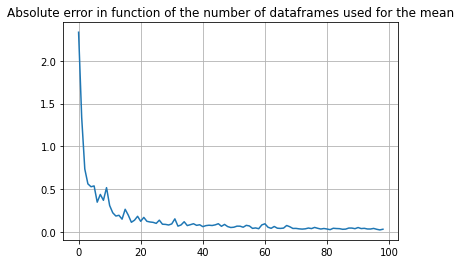

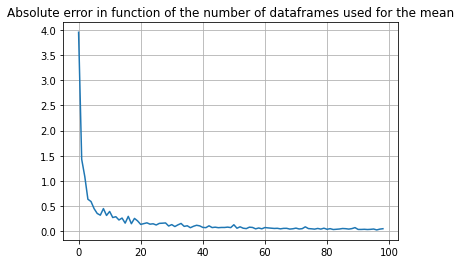

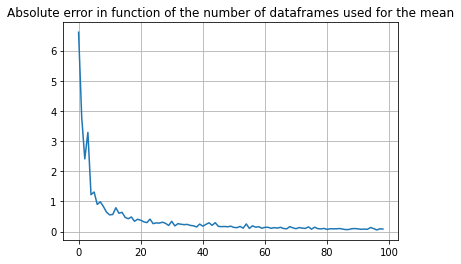

In [7]:
for means in [mean_tot, mean_part_a, mean_part_b]:
    my_errors = []
    for i in range(days*2-1):
        my_errors.append(absolute_error(means[i], means[i+1]))
    plt.figure()
    plt.plot(my_errors)
    plt.grid()
    plt.title('Absolute error in function of the number of dataframes used for the mean')
    plt.show()

In [8]:
df_tot = pd.DataFrame(data={topic: mean_tot[-1], 'date': pd.date_range(start=str(begin_tot), end=str(end_tot))}).set_index('date')
df_part_a = pd.DataFrame(data={topic: mean_part_a[-1], 'date': pd.date_range(start=str(begin_part_a), end=str(end_part_a))}).set_index('date')
df_part_b = pd.DataFrame(data={topic: mean_part_b[-1], 'date': pd.date_range(start=str(begin_part_b), end=str(end_part_b))}).set_index('date')

In [9]:
def merge_trends_batches(left, right, overlap_days, topic):
    """
    return the concatenation of left and right, correctly scaled based on their overlap (in days)

    :param left: accumulator dataframe
    :param right: new dataframe to add to the accumulator
    :param overlap_hour: number of hours that are overlapping
    :param topic: topic considered
    :return df, indexes
        * df: dataframe scaled
        * indexes: indexes of the rescaled data
    """
    if left.empty:
        return right
    # retrieve the overlapping points:
    overlap_start = right.index.min()
    overlap_end = overlap_start + datetime.timedelta(days=overlap_days)
    left_overlap = left[overlap_start:overlap_end]
    right_overlap = right[overlap_start:overlap_end]
    scaling = (left_overlap[topic] / right_overlap[topic]).mean()
    if scaling < 1:  # right has not the good scale
        right_to_add = right[right.index > overlap_end]
        right_to_add = right_to_add * scaling
        indexes = right_to_add.index
        return left.append(right_to_add), indexes
    else:  # left has not the good scale
        left_to_add = left[left.index < overlap_start]
        left_to_add = left_to_add * scaling
        indexes = left_to_add.index
        return left_to_add.append(right), indexes

merged_df = []
for i in range(30):
    start_considered = end_part_a - datetime.timedelta(days=i)
    cur_df_b = df_part_b[start_considered:end_part_b]
    value = merge_trends_batches(df_part_a, cur_df_b, i, topic)
    merged_df.append(value)

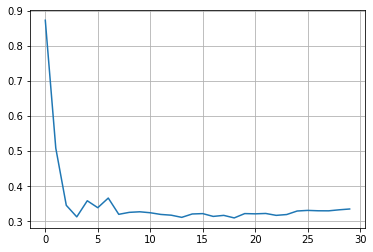

In [10]:
my_errors = []
for i in range(len(merged_df)):
    df, idx = merged_df[i]
    estimated = np.array(df[idx.min():idx.max()][topic])
    truth = np.array(df_tot[idx.min():idx.max()][topic])
    my_errors.append(absolute_error(estimated, truth))
plt.figure()
plt.plot(my_errors)
plt.grid()
plt.show()

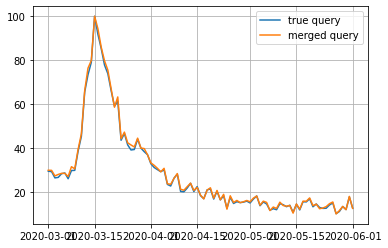

In [14]:
plt.figure()
plt.plot(df_tot, label="true query")
plt.plot(merged_df[-1][0], label="merged query")
plt.legend()
plt.grid()
plt.show()